In [1]:
import sys
sys.path.append("../../src")
sys.path.append("../../data")
sys.path.append("..")

import os
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt

from utils.kernel_utils import ColumnwiseRBF, RBF
from causal_models.proxy_causal_learning import KernelNegativeControlATE
from AlternativeProxyKernel.generate_experiment_data import read_legalized_abortion_and_crime_dataset

In [2]:
data_path = '../../data/abortion'
seed = 9
W, Z, A, Y, do_A, EY_do_A = read_legalized_abortion_and_crime_dataset(data_path, seed)

W, Z, A, Y, do_A, EY_do_A = jnp.array(W), jnp.array(Z), jnp.array(A), jnp.array(Y), jnp.array(do_A), jnp.array(EY_do_A)

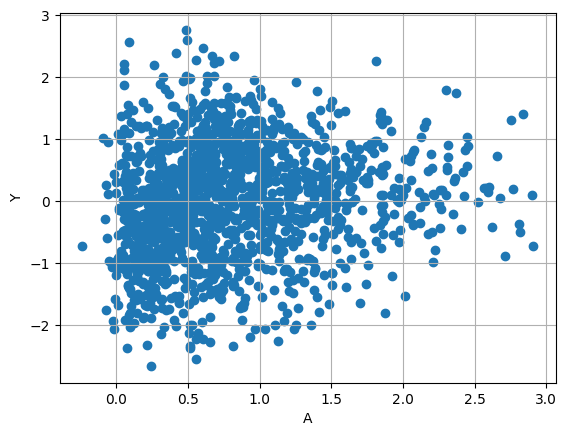

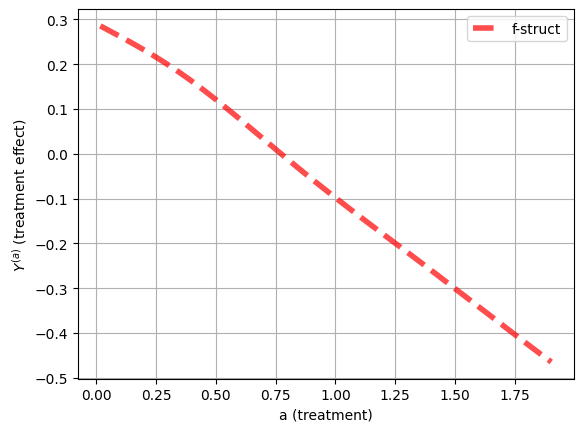

In [3]:
plt.scatter(A, Y)
plt.xlabel("A")
plt.ylabel("Y")
plt.grid()
plt.show()


plt.plot(do_A, EY_do_A, linewidth = 4, color = "red", alpha=0.7, linestyle = "dashed", label = "f-struct")
plt.grid()
plt.xlabel("a (treatment)")
plt.ylabel(r"$Y^{(a)}$ (treatment effect)")
plt.legend()

In [4]:
RBF_Kernel_Z = RBF(use_median_length_scale_heuristic = True, use_jit_call = True)
RBF_Kernel_W = RBF(use_median_length_scale_heuristic = True, use_jit_call = True)
RBF_Kernel_A = RBF(use_median_length_scale_heuristic = True, use_jit_call = True)
RBF_Kernel_X = RBF(use_median_length_scale_heuristic = True, use_jit_call = True)

lambda_ = 0.1
zeta = 5*1e-4
optimize_regularization_parameters = True
lambda_optimization_range = (1e-15, 1.0)
stage1_perc = 0.5
regularization_grid_points = 150

model = KernelNegativeControlATE(
                                 kernel_A = RBF_Kernel_A,
                                 kernel_W = RBF_Kernel_W,
                                 kernel_Z = RBF_Kernel_Z,
                                 kernel_X = RBF_Kernel_X,
                                 lambda_ = lambda_,
                                 zeta = zeta, 
                                 optimize_regularization_parameters = True,
                                 lambda_optimization_range = (1e-9, 1.0),
                                 zeta_optimization_range = (1e-9, 1.0),
                                 large_lambda_zeta_option = False,
                                )

Structured function test set MSE: 0.013739964317996595
Structured function test set MAE: 0.0760478544569369


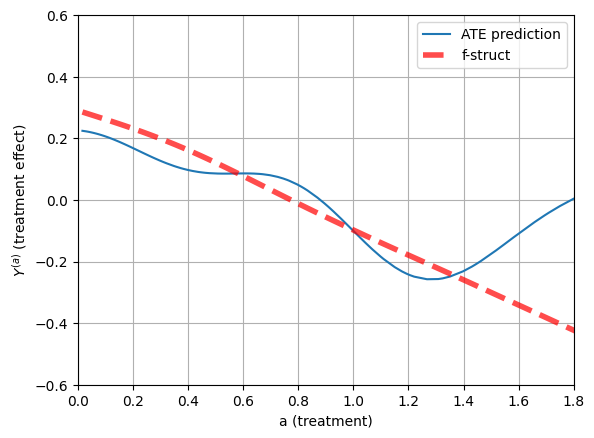

In [5]:
model.fit((A, W, Z, None), Y)

f_struct_pred = model.predict(do_A)

structured_pred_mse = (np.mean((f_struct_pred.reshape(-1, 1) - EY_do_A.reshape(-1, 1)) ** 2))
structured_pred_mae = (np.mean(np.abs(f_struct_pred.reshape(-1, 1) - EY_do_A.reshape(-1, 1))))
print("Structured function test set MSE: {}".format(structured_pred_mse))
print("Structured function test set MAE: {}".format(structured_pred_mae))


plt.plot(do_A, f_struct_pred, label = "ATE prediction")
plt.plot(do_A, EY_do_A, linewidth = 4, color = "red", alpha = 0.7, linestyle = "dashed", label = "f-struct")
plt.grid()
plt.xlabel("a (treatment)")
plt.ylabel(r"$Y^{(a)}$ (treatment effect)")
plt.legend()
plt.xlim(0, 1.8)
plt.ylim(-0.6, 0.6)
plt.show()

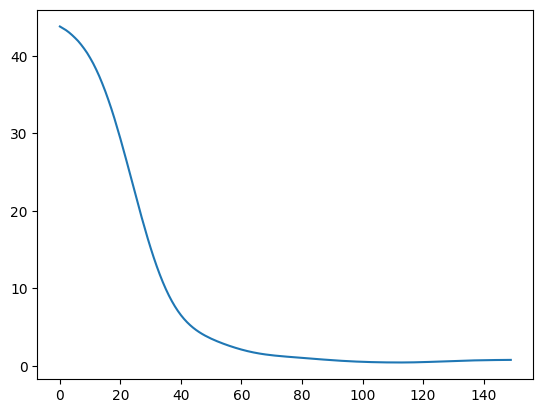

In [6]:
plt.plot(model.zeta_objective_list)

In [8]:
model.zeta

Array(0.00582238, dtype=float64)